In [214]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import zipfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

from skimage import color, io
from scipy.misc import imresize

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Activation, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback
from keras.utils import np_utils
from keras.models import Model

np.random.seed(31337)

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
# Load Squeeznet CNN codes
X_train_squeezenet=np.load('squeezenet_train_preds-86528D.npy')

In [3]:
X_hard_squeezenet= np.load('squeezenet_hard_preds-86528D.npy')

In [4]:
print(X_train_squeezenet.shape)
print(X_hard_squeezenet.shape)


(23814, 13, 13, 512)
(1186, 13, 13, 512)


In [5]:
# labels
Y_train=np.load('catfish-Y_train.npy')
Y_hard=np.load('catfish-Y_hard.npy')
#Y_train = np_utils.to_categorical(Y_train, 2)
#Y_hard = np_utils.to_categorical(Y_hard, 2)

In [171]:
print(Y_train.shape)
print(Y_hard.shape)
Y_train = np_utils.to_categorical(Y_train, 2)
Y_hard = np_utils.to_categorical(Y_hard, 2)

(23814,)
(1186,)


In [215]:
# Build model_squeezenet

model = Sequential()
model.add(Dropout(0.5, name='drop9',input_shape=(13,13,512)))
model.add(Convolution2D(2, 1, 1,border_mode='valid',activation="linear",name="conv10", input_shape=(13,13,512)))
model.add(Activation(activation='relu', name='relu_conv10'))
model.add(GlobalAveragePooling2D())
model.add(Activation(activation='softmax', name='loss'))
model.summary()

# # Compile model_squeezenet
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Callbacks
early_stop_cb = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

checkpoit_cb = ModelCheckpoint("catfish_Convolution2D_classifier.h5", save_best_only=True)

# Print the batch number at the beginning of every batch.
batch_print_cb = LambdaCallback(on_batch_begin=lambda batch, logs: print(".",end=''), 
                                on_epoch_end=lambda batch, logs: print(batch))

# Plot the loss after every epoch.
plot_loss_cb = LambdaCallback(on_epoch_end=lambda epoch, logs: 
                              print (logs))
                              #plt.plot(np.arange(epoch), logs['loss']))


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
drop9 (Dropout)                  (None, 13, 13, 512)   0           dropout_input_18[0][0]           
____________________________________________________________________________________________________
conv10 (Convolution2D)           (None, 13, 13, 2)     1026        drop9[0][0]                      
____________________________________________________________________________________________________
relu_conv10 (Activation)         (None, 13, 13, 2)     0           conv10[0][0]                     
____________________________________________________________________________________________________
globalaveragepooling2d_1 (Global (None, 2)             0           relu_conv10[0][0]                
___________________________________________________________________________________________

In [216]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'],
             )

# Fit the model 
history = model.fit(X_train_squeezenet[:22000], Y_train[:22000], 
                             validation_data=(X_train_squeezenet[22000:], Y_train[22000:]),
                             #validation_split=0.33, 
                             nb_epoch=50, 
                             batch_size=4000, 
                             callbacks=[early_stop_cb, checkpoit_cb, batch_print_cb, plot_loss_cb],
                             verbose=0)

# list all data in history
print(history.history.keys())

......0
{'acc': 0.44672730565071106, 'loss': 1.925785248929804, 'val_acc': 0.45589858293533325, 'val_loss': 1.4531068801879883}
......1
{'acc': 0.50318187475204468, 'loss': 1.3438686674291438, 'val_acc': 0.55567806959152222, 'val_loss': 1.0700684785842896}
......2
{'acc': 0.61618186127055774, 'loss': 0.93013215065002441, 'val_acc': 0.669239342212677, 'val_loss': 0.75283652544021606}
......3
{'acc': 0.70704549551010132, 'loss': 0.70088331265883008, 'val_acc': 0.72877621650695801, 'val_loss': 0.59359109401702881}
......4
{'acc': 0.77304550192572852, 'loss': 0.53760828484188428, 'val_acc': 0.77012133598327637, 'val_loss': 0.50110322237014771}
......5
{'acc': 0.81304553422060877, 'loss': 0.44151618805798615, 'val_acc': 0.81201779842376709, 'val_loss': 0.42966368794441223}
......6
{'acc': 0.84354549104517151, 'loss': 0.37600139596245508, 'val_acc': 0.83406847715377808, 'val_loss': 0.37032151222229004}
......7
{'acc': 0.86327282407067041, 'loss': 0.33269749988209119, 'val_acc': 0.85446530580

In [217]:
score_hard = model.evaluate(X_hard_squeezenet, Y_hard, verbose=0)

print("OOS %s: %.2f%%" % (model.metrics_names[1], score_hard[1]*100))
print("OOS %s: %.2f" % (model.metrics_names[0], score_hard[0]))

print("min(val los)",np.min(history.history['val_loss']))

OOS acc: 92.33%
OOS loss: 0.19
min(val los) 0.0977912023664


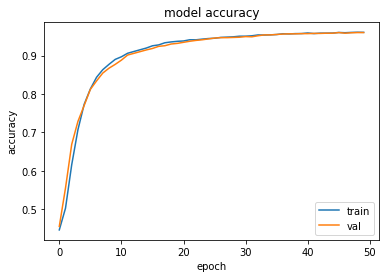

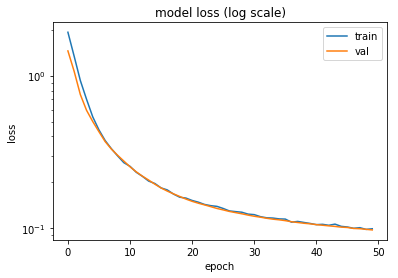

In [218]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss (log scale)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.yscale('log')
plt.show()

In [229]:
from keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'],
             )


# Fit the model 
history = model.fit(X_train_squeezenet[:16000], Y_train[:16000], 
                             validation_data=(X_train_squeezenet[20000:22000], Y_train[20000:22000]),
                             #validation_split=0.33, 
                             nb_epoch=100, 
                             batch_size=4000, 
                             callbacks=[early_stop_cb, checkpoit_cb, batch_print_cb, plot_loss_cb],
                             initial_epoch=50,
                             verbose=0)


....50
{'acc': 0.96137510240077972, 'loss': 0.098303591832518578, 'val_acc': 0.96350002288818359, 'val_loss': 0.086843892931938171}
....51
{'acc': 0.96062511205673218, 'loss': 0.096319388598203659, 'val_acc': 0.96400004625320435, 'val_loss': 0.086790628731250763}
....52
{'acc': 0.96118757128715515, 'loss': 0.097392728552222252, 'val_acc': 0.9645000696182251, 'val_loss': 0.086715668439865112}
....53
{'acc': 0.96093757450580597, 'loss': 0.096868766471743584, 'val_acc': 0.96500009298324585, 'val_loss': 0.086597546935081482}
....54
{'acc': 0.96212513744831085, 'loss': 0.09520980529487133, 'val_acc': 0.96500003337860107, 'val_loss': 0.086455628275871277}
....55
{'acc': 0.96056260168552399, 'loss': 0.095045940950512886, 'val_acc': 0.96500009298324585, 'val_loss': 0.086296647787094116}
....56
{'acc': 0.96312509477138519, 'loss': 0.096294308081269264, 'val_acc': 0.96549999713897705, 'val_loss': 0.086112163960933685}
....57
{'acc': 0.96125008165836334, 'loss': 0.096079995855689049, 'val_acc': 0

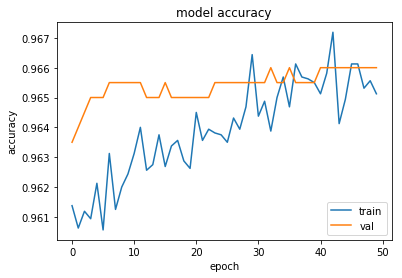

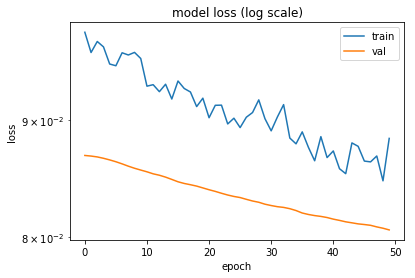

In [230]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss (log scale)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.yscale('log')
plt.show()

In [236]:
score_hard = model.evaluate(X_hard_squeezenet, Y_hard, verbose=0)

print("OOS %s: %.2f%%" % (model.metrics_names[1], score_hard[1]*100))
print("OOS %s: %.2f" % (model.metrics_names[0], score_hard[0]))

print("min(val los)",np.min(history.history['val_loss']))

OOS acc: 92.24%
OOS loss: 0.17
min(val los) 0.0805765688419


In [232]:
from sklearn.metrics import log_loss

Y_train_preds=model.predict(X_train_squeezenet)
Y_hard_preds=model.predict(X_hard_squeezenet)

In [233]:
score_hard = model.evaluate(X_train_squeezenet, Y_train, verbose=0)

print("OOS %s: %.2f%%" % (model.metrics_names[1], score_hard[1]*100))
print("OOS %s: %.2f" % (model.metrics_names[0], score_hard[0]))


OOS acc: 96.75%
OOS loss: 0.08


In [235]:
for i in range(1,10):
    m=i/100.0
    print(m,log_loss(Y_train,Y_train_preds.clip(min=m, max=1-m)),m,log_loss(Y_hard,Y_hard_preds.clip(min=m, max=1-m)))
    
    

0.01 0.0859608004013 0.01 0.176782003828
0.02 0.0932254262986 0.02 0.181356018794
0.03 0.100983118987 0.03 0.186440562658
0.04 0.1090721105 0.04 0.191907269274
0.05 0.117377279798 0.05 0.197914152125
0.06 0.125881397731 0.06 0.204348693195
0.07 0.134575577972 0.07 0.211168072992
0.08 0.143475183693 0.08 0.218303679176
0.09 0.152557854332 0.09 0.22564850502


In [237]:
print(log_loss(Y_train, Y_train_preds))
print(log_loss(Y_hard,Y_hard_preds))

0.0804215156362
0.174303788769


In [205]:
Y_train_preds.clip(min=0.02, max=0.98)
Y_train_preds

array([[  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   6.31518146e-30],
       [  0.00000000e+00,   1.00000000e+00],
       ..., 
       [  0.00000000e+00,   1.00000000e+00],
       [  0.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00]], dtype=float32)